# Adversarial Search: Playing "Mean" Connect 4


## Instructions

All student names in group: Safwan Kader, Jerry Xiao, Dylan Lai

I understand that my submission needs to be my own group's work: SK, JX, DL

I understand that ChatGPT / Copilot / other AI tools are not allowed: SK, JX, DL

Points: 10

Complete this notebook and submit it (save/print as pdf). The notebook needs to be a complete project report with your implementation, documentation including a short discussion of how your implementation works and your design choices, and experimental results (e.g., tables and charts with simulation results) with a short discussion of what they mean. Use the provided notebook cells and insert additional code and markdown cells as needed.

## Introduction

You will implement different versions of agents that play "Mean" Connect 4:

> "Connect 4 is a two-player connection board game, in which the players choose a color and then take turns dropping colored discs into a seven-column, six-row vertically suspended grid. The pieces fall straight down, occupying the lowest available space within the column. The objective of the game is to be the first to form a horizontal, vertical, or diagonal line of four of one's own discs." (see [Connect Four on Wikipedia](https://en.wikipedia.org/wiki/Connect_Four))

> **The mean part:** This game has an additional rule. Every time it is a player's turn, the player can decide to instead of playing a new disk, take a bottom row disk of the opponent and place it back in the top of the same column. All disks above the removed disk will fall down one position and the removed one will be placed on top. Note that a player can only move an _opponent's disc_ that is in the _bottom row_ of the board. **Further, you are not allowed to play a mean move if your opponent just played one.** This ensures the game will end at some point. This also may affect the definition of a board, compared with standard Connect 4.

If a mean move causes both players to win, the game immediately ends and it is a tie, even if one player has more connect-4s than the other one. If a mean move causes one player to win, then the game also ends and the player with the connect-4 is the winner.

Note that normal [Connect-4 has been solved](https://en.wikipedia.org/wiki/Connect_Four#Mathematical_solution)
in 1988. A connect-4 solver with a discussion of how to solve different parts of the problem can be found here: https://connect4.gamesolver.org/en/

## Task 1: Defining the Search Problem [1 point]

**Define the components of the search problem associated with this game:**

* Initial state
* Actions
* Transition model
* Test for the terminal state
* Utility for terminal states

- **Initial State (S₀):** 
  - The initial state is an empty Connect 4 board with no discs placed.
  
- **Actions (A):** 
  - Actions include dropping a disc in one of the seven columns or performing a mean move in one of the columns where the opponent has a disc in the bottom row.
  
- **Transition Model (Result function):** 
  - The transition model defines how the state changes based on the action taken. It returns the new state after applying the action. In this case, the transition model will show how the board will change after a mean move or regular move. 
  
  - *Result(s,a) -> a'* where s is the current state and a is the action taken. a' is the new state. 
  
- **Test for the terminal state:** 
  - We can define a function ```check_board``` which checks whether the game has reached a terminal state. This includes checking for a winner or a tie (full board). Terminal states only require at least one winner or ties. If multiple wins are detected, they will be ignored.
  
- **Utility for terminal states:** 
  - The utility function assigns utility values based on the outcome of the game. It returns a positive value if Max wins, a negative value if Min wins, and 0 for a tie.
 

**How big is the state space? Give an estimate and explain it.**

The state space is estimated as 3^(6*7) since each cell can have three states (empty, player 1, player 2) on a 6x7 board.



**How big is the game tree that minimax search will go through? Give an estimate and explain it.**

The game tree is estimated based on the branching factor (number of possible actions) raised to the depth of the tree. The depth is the maximum number of moves until the end of the game, which is typically less than 42 (6 rows * 7 columns).

## Task 2: Game Environment and Random Agent [3 point]

You can use a numpy character array as the board. Note that the following function can create boards of different sizes.

In [4]:
import numpy as np

def empty_board(shape=(6, 7)):
    return np.full(shape=shape, fill_value=0)

print(empty_board())

[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]


Instead of colors (red and yellow), you can use 1 and -1 to represent the players Max and Min. Make sure that your agent functions all have the from: `agent_type(state, player = 1)`, where board is the current board position and player is the player (1, -1) whose next move it is and who the agent should play.

Visualization code by Randolph Rankin:

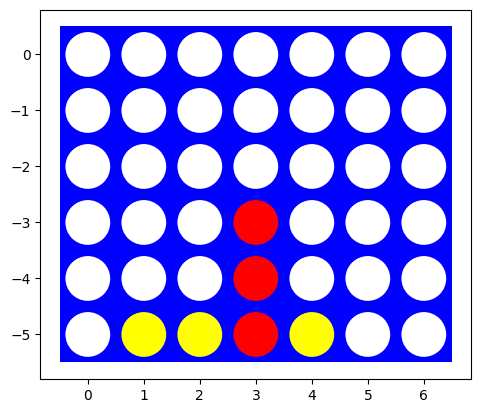

In [89]:
import matplotlib.pyplot as plt

def visualize(board):
    plt.axes()
    rectangle=plt.Rectangle((-0.5,len(board)*-1+0.5),len(board[0]),len(board),fc='blue')
    circles=[]
    for i,row in enumerate(board):
        for j,val in enumerate(row):
            color='white' if val==0 else 'red' if val==1 else 'yellow'
            circles.append(plt.Circle((j,i*-1),0.4,fc=color))

    plt.gca().add_patch(rectangle)
    for circle in circles:
        plt.gca().add_patch(circle)

    plt.axis('scaled')
    plt.show()

board = [[0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0],
         [0,-1,-1, 1,-1, 0, 0]]

visualize(board)

Implement helper functions for:

* The transition model $result(s, a)$.
* The utility function $utility(s)$.
* Check for terminal states $terminal(s)$.
* A check for available actions in each state $actions(s)$.

Make sure that all these functions work with boards of different sizes (number of columns and rows).

In [186]:
import itertools
mean_allowed = True
def action(board, move, player):
    new_board = [row.copy() for row in board]
    if move[0] == 'drop':
        column = move[1]
        for row in range(len(new_board) - 1, -1, -1):
            if new_board[row][column] == 0:
                new_board[row][column] = player 
                break
    elif move[0] == 'mean':
        column = move[1]
        row = len(new_board) - 1
        while new_board[row][column] != 0 and row > 0:
            new_board[row][column] = new_board[row - 1][column]
            row -= 1
        new_board[row + 1][column] = player * -1
    return new_board

def utility(board):
    winner = check_board(board)
    if winner == 1:
        return 100  # player 1 wins
    elif winner == -1:
        return -100  # player 2 wins
    # elif winner == 0:
    #     return 0  # It's a draw
    
    rows = len(board)
    cols = len(board[0])

    # evaluate the board based on the number of connected pieces for the player
    player_count = count_connected_pieces(board, 1, rows, cols)
    opponent_count = count_connected_pieces(board, -1, rows, cols)
    

    return player_count - opponent_count

def count_connected_pieces(board, player, rows, cols):
    # sourcery skip: sum-comprehension, use-itertools-product
    count = 0
    
    # check horizontally
    for row in range(rows):
        for col in range(cols - 1):
            if board[row][col] == player and board[row][col + 1] == player:
                count += 1
                   
    # check vertically
    for row in range(rows - 1):
        for col in range(cols):
            if board[row][col] == player and board[row + 1][col] == player:
                count += 1
             
    # check diagonally (from bottom-left to top-right)
    for row in range(rows - 1):
        for col in range(cols - 1):
            if board[row][col] == player and board[row + 1][col + 1] == player:
                count += 1
            
    # check diagonally (from top-left to bottom-right)
    for row in range(rows - 1):
        for col in range(1, cols):
            if board[row][col] == player and board[row + 1][col - 1] == player:
                count += 1
               
    return count

def is_winning_sequence(sequence):
    winning_sequences = [[1, 1, 1, 1], [-1, -1, -1, -1]]
def is_winning_sequence(sequence):
    winning_sequences = [[1, 1, 1, 1], [-1, -1, -1, -1]]
    return next(
        (
            seq[0]
            for i, seq in itertools.product(
                range(len(sequence) - 3), winning_sequences
            )
            if all(sequence[i + j] == seq[j] for j in range(4))
        ),
        None,
    )


def check_board(board):
    # check rows
    for row in board:
        winner = is_winning_sequence(row)
        if winner is not None:
            return winner

    # check columns
    for col in range(len(board[0])):
        column_values = [board[row][col] for row in range(len(board))]
        winner = is_winning_sequence(column_values)
        if winner is not None:
            return winner

    # check diagonals
    for row in range(len(board) - 3):
        for col in range(len(board[0]) - 3):
            diagonal_values = [board[row + i][col + i] for i in range(4)]
            anti_diagonal_values = [board[row + 3 - i][col + i] for i in range(4)]

            winner = is_winning_sequence(diagonal_values)
            if winner is not None:
                return winner

            winner = is_winning_sequence(anti_diagonal_values)
            if winner is not None:
                return winner

    # check ties
    return 0 if all(cell != 0 for row in board for cell in row) else None

 


def available_actions(board, player, mean_allowed = True):
    actions = []
    
    for column in range(len(board[0])):
        if board[0][column] == 0: 
            actions.append(('drop', column))
            
        last_row = len(board) - 1
        
        if mean_allowed:
            if board[last_row][column] == (player * -1) and board[last_row - 1][column] != 0:
                actions.append(('mean', column))
                
    return actions


Implement an agent that plays randomly. Make sure the agent function receives as the percept the game state and returns a valid action. Use an agent function definition with the following signature (arguments):

`def random_player(state, player = None): ...`

The argument `player` is used for agents that do not store what side they are playing. The value passed on by the environment should be 1 ot -1 for playerred and yellow, respectively.  See [Experiments section for tic-tac-toe](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_and_or_tree_search.ipynb#Experiments) for an example.

In [187]:
import random

def random_player(board, player = None, mean_allowed = True):
    action = available_actions(board, player, mean_allowed)
    return random.choice(action) if action else None

Let two random agents play against each other 1000 times. Look at the [Experiments section for tic-tac-toe](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_and_or_tree_search.ipynb#Experiments) to see how the environment uses the agent functions to play against each other.

How often does each player win? Is the result expected?

In [191]:
def switch_player(player):
    return -1 if player == 1 else 1

def play(N = 1000):
    """Let two agents play each other N times. x starts. x and y are agent functions that 
    get the board as the percept and return their next action."""
    
    results = {'1': 0, '-1': 0, '0': 0}
    
    mean_allowed = True
    
    for _ in range(N):
        
        board = empty_board()
        player = 1
        
        while True:
            
            if move := random_player(board, player, mean_allowed):
                mean_allowed = move[0] != 'mean'
                board = action(board, move, player)
                
            if win := check_board(board):
                results[str(win)] += 1
                break
            
            player = switch_player(player)   
        
    return results

play()

{'1': 594, '-1': 406, '0': 0}

## Task 3: Minimax Search with Alpha-Beta Pruning [3 points]

### Implement the search starting.

Implement the search starting from a given state and specifying the player and put it into an agent function.
You can use code from the [tic-tac-toe example](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_alpha_beta_tree_search.ipynb).

__Notes:__
* Make sure that all your agent functions have a signature consistent with the random agent above.
* The search space for a $6 \times 7$ board is large. You can experiment with smaller boards (the smallest is $4 \times 4$) and/or changing the winning rule to connect 3 instead of 4.

In [197]:
import math

# global variables
DEBUG = 1 # 1 ... count nodes, 2 ... debug each node
COUNT = 0

def alpha_beta_search(board, player = 1):  # sourcery skip: move-assign
    """start the search."""
    global DEBUG, COUNT
    COUNT = 0
    
    print('calling alpha-beta pruning function')
    value, move = max_value_ab(board, player, -math.inf, +math.inf)
    
    if DEBUG >= 1: print(f"Number of nodes searched: {COUNT}") 
    
    return { "move": move, "value": value }

def max_value_ab(state, player, alpha, beta):
    """player's best move."""
    global DEBUG, COUNT
    COUNT += 1

    # return utility of state is a terminal state
    print("checking utility")
    v = utility(state)
    print("utility of current state :",v)
    if DEBUG >= 2: print(f"max: {state} [alpha,beta]=[{alpha},{beta}] v={v}")
    if v in [100, -100]: 
        if DEBUG >= 2:
            print("     found terminal state. backtracking.")
        return v, None

    
    v, move = -math.inf, None

    # check all possible actions in the state, update alpha and return move with the largest value
    for a in available_actions(state,player):
        v2, a2 = min_value_ab(action(state, a, player), player, alpha, beta)
        if DEBUG >= 2: print(f"max: {state} (backtracked) [alpha,beta]=[{alpha},{beta}] v={v2}")

        if v2 > v:
            v, move = v2, a
            alpha = max(alpha, v)
        if v >= beta:
            if DEBUG >= 2: print(f"     v>=beta ({v}>={beta}): pruning remaining subtree (actions). backtracking.")
            return v, move

    return v, move

def min_value_ab(state, player, alpha, beta):
    """opponent's best response."""
    global DEBUG, COUNT
    COUNT += 1

    # return utility of state is a terminal state
    v = utility(state)
    if DEBUG >= 2: print(f"min: {state} [alpha,beta]=[{alpha},{beta}] v={v}")
    if v is not None: 
        if DEBUG >= 2:
            print("     found terminal state. backtracking.")
        return v, None

    v, move = +math.inf, None

    # check all possible actions in the state, update beta and return move with the smallest value
    for a in available_actions(state, player):
        v2, a2 = max_value_ab(action(state, a, switch_player(player)), player, alpha, beta)
        if DEBUG >= 2: print(f"min: {state} (backtracked) [alpha,beta]=[{alpha},{beta}] v={v2}")

        if v2 < v:
            v, move = v2, a
            beta = min(beta, v)
        if v <= alpha: 
            if DEBUG >= 2: print(f"     v<=alpha ({v}<={alpha}): pruning remaining subtree (actions). backtracking.")
            return v, move

    return v, move

Experiment with some manually created boards (at least 5) to check if the agent spots winning opportunities.

Board:


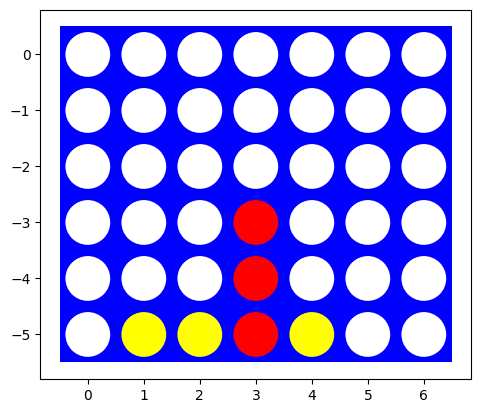


calling alpha-beta pruning function
checking utility
utility of current state : 1
Number of nodes searched: 8


{'move': ('drop', 3), 'value': 100}

CPU times: user 4.56 ms, sys: 131 µs, total: 4.69 ms
Wall time: 1.44 ms


In [198]:
# win in column 2
board1 = [[0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0],
          [0, 0, 1, 0, 0, 0, 0],
          [0, 0, 1, 1, 0, 0, 0],
          [0, 0, 1, 1, 0, 0, 0],
          [0, 0,-1,-1,-1, 0, 0]]

print("Board:")
visualize(board)

print()
%time display(alpha_beta_search(board))
# win in column 1
board2 = [[0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0],
          [0, 1, 0, 0, 0, 0, 0],
          [0, 1, 0, 0, 0, 0, 0],
          [0, 1, 0, 0, 0, 0, 0],
          [0,-1,-1,-1, 0, 0, 0]]

# win in diagonal
board3 = [[0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0],
          [0, -1, 1, 0, 0, 0, 0],
          [0, -1, 1, 1, 0, 0, 0],
          [0,-1, -1,-1, 1, 0, 0]]

# win in anti-diagonal
board4 = [[0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0],
          [0, -1, -1, 1, 1, 0, 0],
          [0, -1, 1, 1, -1, 0, 0],
          [0, 1, -1, -1, 1, 0, 0]]

# win in row 4
board5 = [[0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0],
          [0, 0, 1, 1, 1, 0, 0],
          [0, 0, 1,-1, 1, -1, 0],
          [0,-1,-1, 1,-1, -1, 0]]


How long does it take to make a move? Start with a smaller board with 4 columns and make the board larger by adding columns.

In [ ]:
# Your code/ answer goes here.

### Move ordering

Starting the search with better moves will increase the efficiency of alpha-beta pruning. Describe and implement a simple move ordering strategy. Make a table that shows how the ordering strategies influence the time it takes to make a move.

In [ ]:
# Your code/ answer goes here.

### The first few moves

Start with an empty board. This is the worst case scenario for minimax search with alpha-beta pruning since it needs solve all possible games that can be played (minus some pruning) before making the decision. What can you do?

In [ ]:
# Your code/ answer goes here.

### Playtime

Let the Minimax Search agent play a random agent on a small board. Analyze wins, losses and draws.

In [ ]:
# Your code/ answer goes here.

## Task 4: Heuristic Alpha-Beta Tree Search [3 points]

### Heuristic evaluation function

Define and implement a heuristic evaluation function.

In [ ]:
# Your code/ answer goes here.

### Cutting off search

Modify your Minimax Search with Alpha-Beta Pruning to cut off search at a specified depth and use the heuristic evaluation function. Experiment with different cutoff values.

In [ ]:
# Your code/ answer goes here.

Experiment with the same manually created boards as above to check if the agent spots winning opportunities.

In [ ]:
# Your code/ answer goes here.

How long does it take to make a move? Start with a smaller board with 4 columns and make the board larger by adding columns.

In [ ]:
# Your code/ answer goes here.

### Playtime

Let two heuristic search agents (different cutoff depth, different heuristic evaluation function) compete against each other on a reasonably sized board. Since there is no randomness, you only need to let them play once.

In [ ]:
# Your code/ answer goes here.

---
Assignment adapted from [Michael Hahsler](https://github.com/mhahsler/CS7320-AI) under [CC BY-SA](https://creativecommons.org/licenses/by-sa/4.0/deed.en) license.
